In [55]:
import pandas as pd
import sys
sys.path.append('..')
from src.etl import build_intervals
from src.stats import analyze_distribution
from src.viz import plot_multi_category_kde
from src.viz import plot_summary_comparison


In [41]:
raw_df = pd.read_csv(
    "../data/raw/sample_retail_transactions.csv",
    encoding='utf-8',
    encoding_errors='ignore',
    on_bad_lines="skip",
    delimiter=','
)
# 將 InvoiceDate 轉為 datetime
raw_df['purchase_date'] = pd.to_datetime(raw_df['InvoiceDate'], errors='coerce')
raw_df['uid'] = raw_df['CustomerID'].astype(str)
raw_df['it_name'] = raw_df['Description'].astype(str)
# raw_df['cat'] = raw_df['Category'].astype(str)

In [42]:
# 1. 建立 interval_df
interval_df = build_intervals(raw_df, min_purchase=2, category_col="Category")


In [44]:
interval_df.head()

,CustomerID,InvoiceNo,InvoiceDate,Description,Category,Quantity,UnitPrice,Country,purchase_date,uid,it_name,prev_purchase_date,interval_days,purchase_seq,purchase_month,prev_purchase_month
0,U0001,INV000001,2023-01-11 00:00:00,Eggs,Groceries,2,25.782601,Australia,2023-01-11,U0001,Eggs,NaT,NaN,1,2023-01,NaT
1,U0001,INV000002,2023-01-22 00:00:00,Milk,Groceries,4,39.544812,USA,2023-01-22,U0001,Milk,2023-01-11,11.0,2,2023-01,2023-01
2,U0001,INV000003,2023-01-29 00:00:00,Bread,Groceries,4,28.453226,Canada,2023-01-29,U0001,Bread,2023-01-22,7.0,3,2023-01,2023-01
3,U0001,INV000004,2023-02-08 00:00:00,Bread,Groceries,3,33.583439,USA,2023-02-08,U0001,Bread,2023-01-29,10.0,4,2023-02,2023-01
4,U0001,INV000005,2023-02-23 00:00:00,Milk,Groceries,3,62.908612,UK,2023-02-23,U0001,Milk,2023-02-08,15.0,5,2023-02,2023-02


In [45]:
# 2. 產出統計報告
dist_report = analyze_distribution(interval_df, group_cols=["Category"])

In [46]:
dist_report.head()

,Category,n,mean,median,std,iqr,cv,skew,kurtosis,shapiro_p,dip_stat,dip_p,n_kde_peaks,kde_peaks
0,Supplements,1725.0,50.566957,49.0,23.881493,34.0,0.472275,0.542689,-1.042546,1.580740e-33,0.056066,0.0,4,"[29.386767822711413, 59.20121097277952, 75.290..."
1,Groceries,8650.0,10.006243,10.0,4.020925,6.0,0.401842,0.027992,-1.115332,2.185903e-35,0.061742,0.0,2,"[6.4628540196669215, 13.455464301143504]"
2,Electronics,2993.0,29.487471,29.0,5.041531,7.0,0.170972,0.018257,-0.083363,1.485733e-06,0.039258,0.0,1,[29.153829523317636]


In [47]:
display(dist_report)

,Category,n,mean,median,std,iqr,cv,skew,kurtosis,shapiro_p,dip_stat,dip_p,n_kde_peaks,kde_peaks
0,Supplements,1725.0,50.566957,49.0,23.881493,34.0,0.472275,0.542689,-1.042546,1.580740e-33,0.056066,0.0,4,"[29.386767822711413, 59.20121097277952, 75.290..."
1,Groceries,8650.0,10.006243,10.0,4.020925,6.0,0.401842,0.027992,-1.115332,2.185903e-35,0.061742,0.0,2,"[6.4628540196669215, 13.455464301143504]"
2,Electronics,2993.0,29.487471,29.0,5.041531,7.0,0.170972,0.018257,-0.083363,1.485733e-06,0.039258,0.0,1,[29.153829523317636]


In [48]:
# 3. 將每個分類的峰值整理成 dict
kde_peaks_map = {
    row["Category"]: row["kde_peaks"] for _, row in dist_report.iterrows()
    if isinstance(row["kde_peaks"], list)
}

In [50]:
interval_df.Category.value_counts()

Category
Groceries      8772
Electronics    3119
Supplements    1852
Name: count, dtype: int64

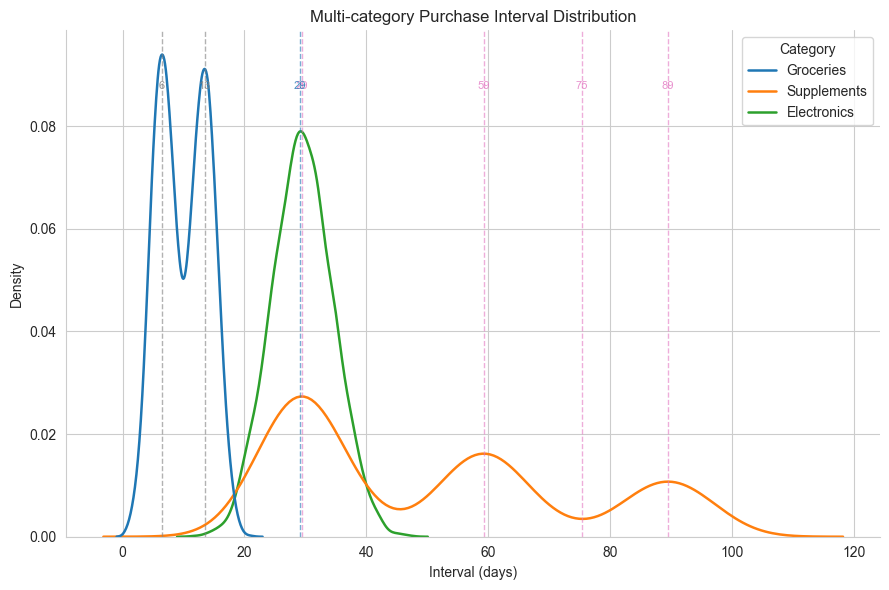

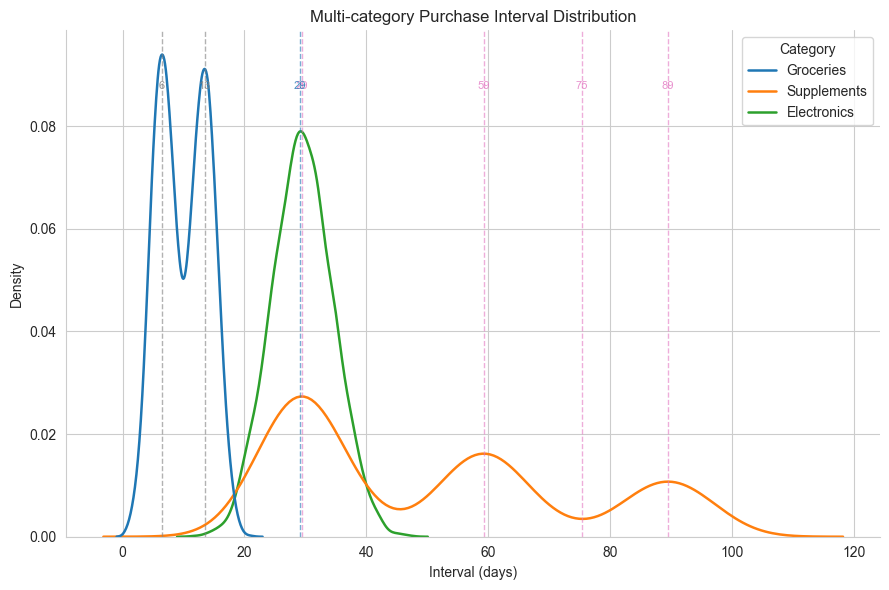

In [57]:

# 4. 畫多分類 KDE
plot_multi_category_kde(
    interval_df,
    interval_col="interval_days",
    category_col="Category",
    kde_peaks_map=kde_peaks_map,
)

In [26]:
dist_report

,cat,n,mean,median,std,iqr,cv,skew,kurtosis,shapiro_p,dip_stat,dip_p,n_kde_peaks,kde_peaks
0,thrown away,2.0,111.500000,111.5,112.429978,79.50,1.008341,NaN,NaN,NaN,NaN,NaN,4,"[32.027490882268864, 52.350205192321255, 170.6..."
1,smashed,3.0,66.000000,29.0,65.825527,57.50,0.997356,1.730252,NaN,2.901508e-02,0.166667,1.000000,4,"[27.959829266250907, 123.54139227518955, 125.6..."
2,missing,2.0,91.000000,91.0,67.882251,48.00,0.745959,NaN,NaN,NaN,NaN,NaN,4,"[43.01659826853968, 50.63711159870431, 131.362..."
3,found,20.0,15.850000,6.0,22.560503,6.00,1.423376,1.924312,2.276773,3.751337e-06,0.054661,0.926093,5,"[5.434981055357187, 27.997778115217045, 60.030..."
4,dotcom,4.0,34.500000,19.0,43.577517,36.00,1.263116,1.678233,2.844854,1.600513e-01,0.125000,0.400000,4,"[12.623868174985901, 71.07752252312369, 87.074..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3284,NINE DRAWER OFFICE TIDY,3.0,18.000000,13.0,19.974984,19.50,1.109721,1.055832,NaN,5.826723e-01,0.166667,1.000000,3,"[7.210007021626705, 37.18106060512521, 38.6771..."
3285,I LOVE LONDON MINI BACKPACK,22.0,19.454545,9.0,19.453797,21.75,0.999962,1.042074,-0.176941,1.351670e-03,0.069930,0.510285,2,"[5.933104363266715, 54.6524626540963]"
3286,DOLLY GIRL BEAKER,60.0,18.600000,10.0,22.836337,24.00,1.227760,2.063672,4.856617,1.161940e-08,0.058333,0.122319,3,"[5.180415118229572, 92.6512486711521, 110.3243..."
3287,50'S CHRISTMAS GIFT BAG LARGE,18.0,10.722222,5.0,14.997276,7.25,1.398710,1.946623,2.737914,2.893695e-05,0.069444,0.688207,4,"[2.9313803131724754, 29.005720264800296, 37.61..."


/Users/williamhuang/Documents/RepurchaseCycleAnalysis/notebooks/../src/viz.py:266: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


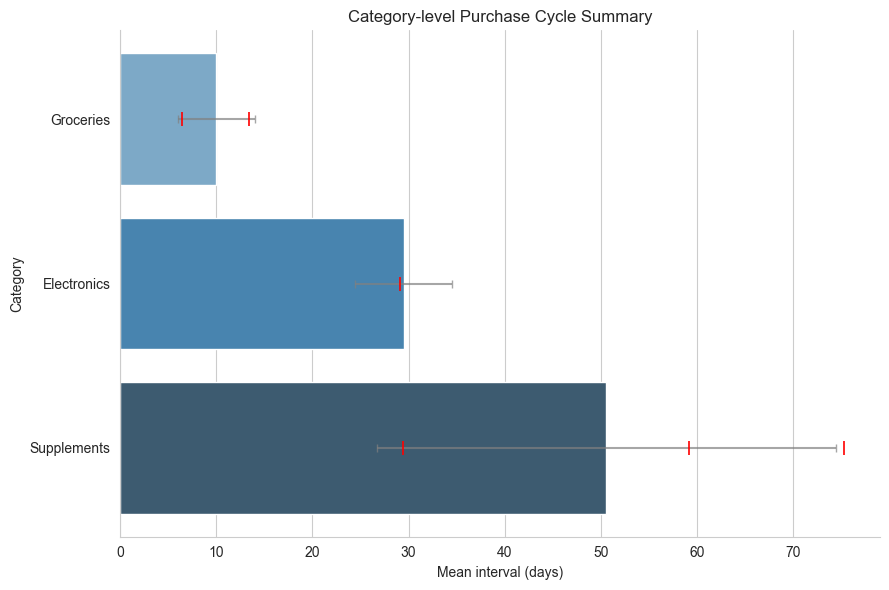

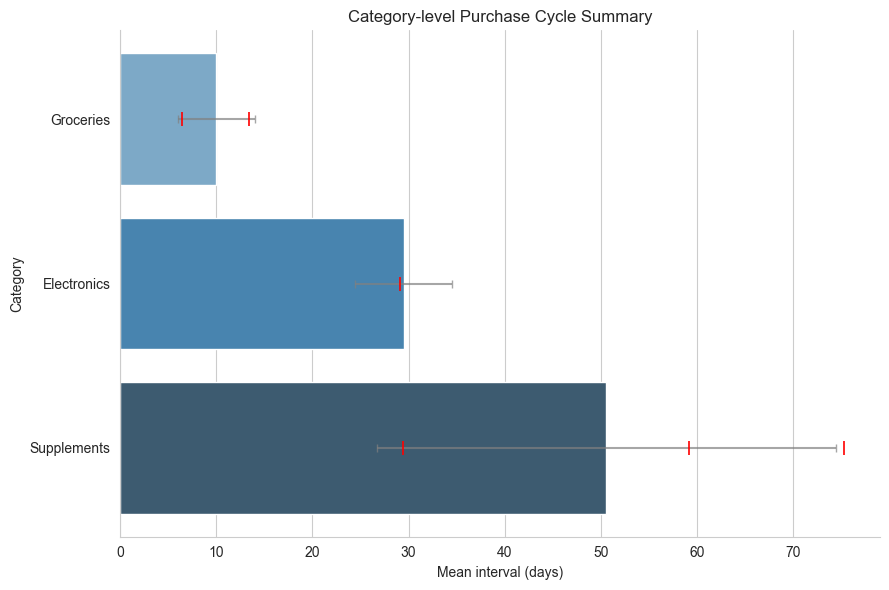

In [54]:
# dist_report 為 analyze_distribution 的結果
plot_summary_comparison(
    summary_df=dist_report,
    category_col="Category",
    value_col="mean",     # 可換成 median
    error_col="std",      # 或 cv
    peaks_col="kde_peaks",
)


In [69]:
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt

# 範例資料
data = sns.load_dataset("penguins")

# Raincloud-like Plot for Seaborn 0.13.2 (no `side` argument)
p = (
    so.Plot(data, x="body_mass_g", y="species", color="species")
    # KDE (雲層)
    .add(so.Area(), so.KDE(), alpha=0.4)
    # 箱形近似區間 (IQR + median)
    .add(so.Range(), so.Est("median"), width=0.3, alpha=0.6)
    # 雨滴散點
    .add(so.Dots(), jitter=0.3, alpha=0.6)
    .layout(size=(8, 5))
    .label(x="Body Mass (g)", y="Species", title="Raincloud-style Plot (Seaborn 0.13.2)")
)

#p.show()


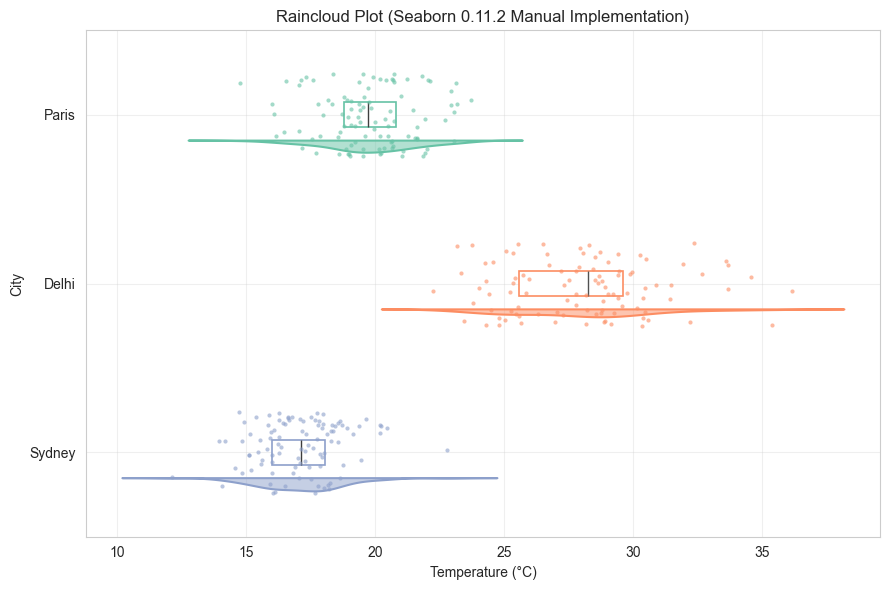

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -----------------------------
# 模擬資料
# -----------------------------
np.random.seed(42)
data = pd.DataFrame({
    "city": np.repeat(["Paris", "Delhi", "Sydney"], 100),
    "temp": np.concatenate([
        np.random.normal(20, 2, 100),
        np.random.normal(28, 3, 100),
        np.random.normal(17, 1.5, 100)
    ])
})

# -----------------------------
# 自製 Raincloud Plot（半雲形）
# -----------------------------
plt.figure(figsize=(9, 6))
palette = sns.color_palette("Set2", n_colors=len(data["city"].unique()))

# 定義 city 的順序與 Y 位置
cities = data["city"].unique()
y_positions = np.arange(len(cities))

for i, (city, color) in enumerate(zip(cities, palette)):
    subset = data[data["city"] == city]
    
    # KDE: 雲層（上半邊）
    sns.kdeplot(
        subset["temp"], 
        fill=True, 
        alpha=0.5, 
        linewidth=1.5, 
        color=color,
        clip=(subset["temp"].min()-2, subset["temp"].max()+2)
    )
    # 取出上半邊曲線並往上偏移
    ax = plt.gca()
    for coll in ax.collections[-1:]:
        verts = coll.get_paths()[0].vertices
        verts[:,1] = verts[:,1]/3 + y_positions[i] + 0.15  # 控制高度與位移

    # Box Plot
    sns.boxplot(
        x="temp", y="city",
        data=subset,
        whis=[0, 100],
        width=0.15,
        showcaps=False,
        boxprops={'facecolor':'white', 'edgecolor':color, 'linewidth':1.2},
        whiskerprops={'linewidth':0},
        showfliers=False,
        orient='h'
    )

    # Strip Plot: 雨點
    sns.stripplot(
        x="temp", y="city",
        data=subset,
        color=color,
        alpha=0.6,
        size=3,
        jitter=0.25,
        orient='h'
    )

plt.title("Raincloud Plot (Seaborn 0.11.2 Manual Implementation)")
plt.xlabel("Temperature (°C)")
plt.ylabel("City")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
